# Implementation of vCC

The following is VQE code using the scipy.optimize.minimize in the classical optimisation loop, and the vCC ansatz that uses lcu and fpoaa functions from _vcc_lcu for state preparation.

In [1]:
import numpy as np                          # for rank_1_projector and other custom matrices
import math
import matplotlib.pyplot as plt
from collections import Counter

from projectq import MainEngine
from projectq.ops import H, Ry, Rx, X, Y, Z, R, Ph, All, Measure, ControlledGate
                                            # Ph for global phase
                                            # R is for phase gates
from projectq.ops._basics import SelfInverseGate
                                            # because they don't have a named identity
        
from projectq.meta import Dagger, Compute, Uncompute, Control

from projectq.ops import QubitOperator
from openfermion.ops import FermionOperator

from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner

from _vcc_lcu import *

In [2]:
def my_jordan_wigner(fermion_op):
    qubit_op = jordan_wigner(fermion_op)
    good_qop = QubitOperator()
    for term in qubit_op.terms:
        good_qop += QubitOperator(term, qubit_op.terms[term])
    return good_qop


def cc_quantum_coprocessor(amps, *ccargs):
    ###################################################
    # CAN YOU DO EACH TERM FOR ITS OWN NUMBER OF REPS #
    # INSTEAD OF MAX REP? WILL THAT SAVE TIME?        #
    ###################################################
    """
    Arguments:
        theta (float): variational parameters for ansatz wavefunction
        hamiltonian (QubitOperator): Hamiltonian of the system
    Returns:
        energy of the trial wavefunction for parameter theta
    """
    
    # unpack arguments
    hamiltonian = ccargs[0]
    n_orbitals = ccargs[1]
    n_electrons = ccargs[2]
    terms = ccargs[3]
    eng = ccargs[4]

#     print('\n The hamiltonian they gave me is:\n')
#     print(hamiltonian)
    
    n_unocc = n_orbitals - n_electrons
    
    unocc = eng.allocate_qureg(n_unocc)
    occ = eng.allocate_qureg(n_electrons)
    cc_trial = occ+unocc
    # operator for making Hartree-Fock initial state |11...10...0>
    # a^+ ---> sigma_-, so |vac> ---> 0 = unoccupied; _occ_&_unocc_
    hf_str = tuple((index, 'X') for
                              index in range(n_electrons))
    hf_init_op = QubitOperator(hf_str, 1.0)
#     print(hf_init_op)
    
    # Allocate LCU control reg - depends on excitation order trunc
    trunc = 2
    ctrl_dim = 2*trunc + 1
    ctrl = eng.allocate_qureg(ctrl_dim)
    # the lcu algo takes the state [ctrl|occ|unocc]
    cc_lcu = ctrl+cc_trial
                
    # save the max of all amps to determine fpoaa depth
    t_max = np.amax([abs(x) for x in amps])
    # and convert amps to lists of nonzeros, with indices, coeft, and number of time slices
    time_slicing_threshold = 0.05
    # save number of nonzeros for later use
    n_terms = np.count_nonzero(amps)
    
    # set success probability level for LCU steps, p_succ = 1-eps
    # eps in our method depends on the max number of 'time' slices 
    # and the total number of terms, as eps = 1/CrM
    # this give overall succ probability of the method as ~ (1/e)^1/C, in theory
    # C=5 gives p > 0.81
    C = 10
    r = math.ceil(t_max/time_slicing_threshold)
#     print('max_r = {}'.format(r))
    eps = 1.0/(C*r*n_terms)
#     print('eps = {}'.format(eps))
    
    # fpoaa depth k => 3^k = (log p_fail)/(log 2t_max)
    fpoaa_queries = math.log(eps, 10)/math.log(2*t_max, 10)
    if (fpoaa_queries>=3):
        fpoaa_depth = math.ceil(math.log(fpoaa_queries,3))
    else:
        fpoaa_depth = 0    
#     print('fpoaa_depth = {}'.format(fpoaa_depth))
    
    # Apply lcu term by term, first all singles, then all doubles
    # Loop over this until success
    # start from top every time LCU+post fails
    done = False
    num_tarings = 0
    while(not done):
        # tare to all zeros state (when picking up from failed LCU)
        for i in range(0,n_orbitals+ctrl_dim):
            Measure | cc_lcu[i]
            if(bool(cc_lcu[i])):
                X | cc_lcu[i]
            num_tarings += 1
        # set unocc orbitals to 1 (0 = occ)
        eng.flush()
        hf_init_op | occ

        for term in terms:
            idx = terms[term]
            t = amps[idx]
            if not t:
                continue
            list_u = []
            term_id = [int(s) for s in term.split(',')]
            if len(term_id) == 2:
                i, j = sorted(term_id)
                op_str = str(j)+'^'+' '+str(i)
                coefts = [0.25*t/r for x in range(4)]
                coefts = np.concatenate(([1.0], coefts))
    #             print('\n LCU coefficients in singles term {}{}, and the lcu'.format(i, j))
    #             print(coefts)
    #             print(list_u)
            elif len(term_id) == 4:
                i,j,k,l = sorted(term_id)
                op_str = str(k)+'^'+' '+str(l)+'^'+' '+str(j)+' '+str(i)
                coefts = [0.0625*t/r for x in range(16)]
                coefts = np.concatenate(([1.0], coefts))
            
            fer_op = FermionOperator(op_str, 1.0)
            qub_op = QubitOperator('', 1.0) + my_jordan_wigner(fer_op)
            for term in qub_op.terms:
                coeft = qub_op.terms[term]/abs(qub_op.terms[term])
                list_u += [QubitOperator(term, coeft)]
        
            if not list_u:
                print('lcu term {} is empty!!'.format(op_str))
            for i in range(0, r):
                lcu(eng, list_u, coefts, ctrl, cc_trial, ctrl_dim, n_orbitals, fpoaa_depth)
                eng.flush()
                done = bool(postselect(ctrl, ctrl_dim))
                if not done:
                    break
    
#         if done:
#             print('Finished doubles...')
            
#     print('Had to repeat {} times'.format(num_tarings))
    # flush all gates
    eng.flush()
#     print("-----Amplitudes of CC_trial state----")
#     print_probabilities(eng, cc_lcu, n_orbitals+ctrl_dim)
    # Calculate the energy.
    # ProjectQ simulator can directly return expectation values
    # In reality need to implement Hamiltonian averaging term-wise
    energy = eng.backend.get_expectation_value(hamiltonian, cc_trial)
    energy_opter = pow(10, 10*abs(energy))
    print('Measured trial energy = {}'.format(energy))
    # Measure all to satisfy projectq simulator
    eng.flush()
    All(Measure) | cc_lcu
    eng.flush()
    return energy

{'0,2': 0, '0,3': 1, '1,2': 2, '1,3': 3, '0,1,2,3': 4}
ground energy and state by diagonalising the hamiltonian:
(-1.1227671716+0j)


/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/projectq/backends/_sim/_simulator.py:175: ComplexWarning: Casting complex values to real discards the imaginary part
  [qb.id for qb in qureg])


Measured trial energy = -1.0872073723853903
Measured trial energy = -1.0872073723853903
Measured trial energy = -1.0872073723853903
Measured trial energy = -1.0872073723853903
Measured trial energy = -1.0872073723853903
Measured trial energy = -1.086019885565945
Measured trial energy = -1.0883759509021589
Measured trial energy = -1.088838077358587
Measured trial energy = -1.087864108911635
Measured trial energy = -1.088125141343478
Measured trial energy = -1.0884889896025618
Measured trial energy = -1.0889952442478237
Measured trial energy = -1.0893474458546555
Measured trial energy = -1.089837513793903
Measured trial energy = -1.0903517581100801
Measured trial energy = -1.0901857473597127
Measured trial energy = -1.0907424623436255
Measured trial energy = -1.091253924347813
Measured trial energy = -1.0914790431601435
Measured trial energy = -1.0920611109455762
Measured trial energy = -1.092406920873735
Measured trial energy = -1.093097495287079
Measured trial energy = -1.0933876895089

Measured trial energy = -1.1069269895254297
Measured trial energy = -1.1069289356118077
Measured trial energy = -1.1069273963515769
Measured trial energy = -1.1069289288157766
vccsd amps:
[  1.01112160e-03   1.14412476e-03   1.14139049e-03   4.13640060e-04
  -4.09729465e-06]
psi4 ccsd amps:
[0.0, 0.0, 0.0, 0.0, -0.04531169845]
max change in magnitude of any cc amplitude: 0.0453076011553539
H2_sto-3g_singlet_0.62 has vCCSD energy of -1.1069289356118077 Hartree at r=0.62.
{'0,2': 0, '0,3': 1, '1,2': 2, '1,3': 3, '0,1,2,3': 4}
ground energy and state by diagonalising the hamiltonian:
(-1.12784213359+0j)
Measured trial energy = -1.090700509268605
Measured trial energy = -1.090700509268605
Measured trial energy = -1.090700509268605
Measured trial energy = -1.090700509268605
Measured trial energy = -1.090700509268605
Measured trial energy = -1.0894608295524577
Measured trial energy = -1.0919205085568524
Measured trial energy = -1.0924029857997515
Measured trial energy = -1.0913861369341218
M

Measured trial energy = -1.111291924630637
Measured trial energy = -1.1112950762909093
Measured trial energy = -1.111292331347012
Measured trial energy = -1.1112957141864857
Measured trial energy = -1.111292893095982
Measured trial energy = -1.1112956326446255
Measured trial energy = -1.1112933755123142
Measured trial energy = -1.111296170736825
Measured trial energy = -1.111293985127834
Measured trial energy = -1.1112961360481466
Measured trial energy = -1.1112938267131434
Measured trial energy = -1.111296386391872
Measured trial energy = -1.1112945102422929
Measured trial energy = -1.1112963581795507
Measured trial energy = -1.1112946655919473
Measured trial energy = -1.1112966985736612
Measured trial energy = -1.1112950905834158
Measured trial energy = -1.1112966914741784
Measured trial energy = -1.1112953349181995
Measured trial energy = -1.11129699674397
vccsd amps:
[  1.01036160e-03   1.14375564e-03   1.14202577e-03   4.13526514e-04
  -3.40690673e-06]
psi4 ccsd amps:
[0.0, 0.0, 0

Measured trial energy = -1.1143838551866558
Measured trial energy = -1.1143904576777557
Measured trial energy = -1.114383923189433
Measured trial energy = -1.114391201736049
Measured trial energy = -1.1143853539581499
Measured trial energy = -1.1143911190898268
Measured trial energy = -1.1143859278900519
Measured trial energy = -1.1143920994867151
Measured trial energy = -1.1143875843886106
Measured trial energy = -1.1143921207004803
Measured trial energy = -1.114388092945644
Measured trial energy = -1.1143929999953521
Measured trial energy = -1.114389126001888
Measured trial energy = -1.114392908854559
Measured trial energy = -1.1143889390634736
Measured trial energy = -1.1143933975718714
Measured trial energy = -1.1143899900116114
Measured trial energy = -1.114393281855243
Measured trial energy = -1.1143904148183976
Measured trial energy = -1.114393948123937
Measured trial energy = -1.1143910015535075
Measured trial energy = -1.1143938629551549
Measured trial energy = -1.114391505427

Measured trial energy = -1.1163430506739325
Measured trial energy = -1.1163575996377029
Measured trial energy = -1.1163458981431862
Measured trial energy = -1.1163600376339136
Measured trial energy = -1.1163486734438566
Measured trial energy = -1.116360192456129
Measured trial energy = -1.1163482291962765
Measured trial energy = -1.1163611494534578
Measured trial energy = -1.116351434762767
Measured trial energy = -1.1163613617398962
Measured trial energy = -1.1163522359176852
Measured trial energy = -1.116363123741851
Measured trial energy = -1.116354776631498
Measured trial energy = -1.1163627299720509
Measured trial energy = -1.1163560762271598
Measured trial energy = -1.1163644629378098
Measured trial energy = -1.1163574545975896
Measured trial energy = -1.1163643494867987
Measured trial energy = -1.1163575256119378
Measured trial energy = -1.1163651264965406
Measured trial energy = -1.1163590197436373
Measured trial energy = -1.1163650401902365
Measured trial energy = -1.116359619

Measured trial energy = -1.1173211871386062
Measured trial energy = -1.117290895974931
Measured trial energy = -1.1173211448918834
Measured trial energy = -1.117294189819137
Measured trial energy = -1.1173258361268965
Measured trial energy = -1.1173024589878797
Measured trial energy = -1.1173263310072161
Measured trial energy = -1.1173050265833657
Measured trial energy = -1.1173308581375325
Measured trial energy = -1.117310815294434
Measured trial energy = -1.1173300476109964
Measured trial energy = -1.1173094775888703
Measured trial energy = -1.1173329496637328
Measured trial energy = -1.1173152714422916
Measured trial energy = -1.1173319711161869
Measured trial energy = -1.1173174664987917
Measured trial energy = -1.1173354215471472
Measured trial energy = -1.1173201671018311
Measured trial energy = -1.1173353573235467
Measured trial energy = -1.1173231400753294
Measured trial energy = -1.1173379027769872
Measured trial energy = -1.1173260376995438
Measured trial energy = -1.11733806

Measured trial energy = -1.1173802374055972
Measured trial energy = -1.1173187159673263
Measured trial energy = -1.1173896558230167
Measured trial energy = -1.1173282695448419
Measured trial energy = -1.117390758171553
Measured trial energy = -1.1173313026251628
Measured trial energy = -1.117395393467924
Measured trial energy = -1.1173422113295637
Measured trial energy = -1.1173969087657853
Measured trial energy = -1.1173495837977687
Measured trial energy = -1.1174035762542593
Measured trial energy = -1.1173625673039516
Measured trial energy = -1.1174060330759714
Measured trial energy = -1.117369496992195
Measured trial energy = -1.117412587146426
Measured trial energy = -1.1173761577423242
Measured trial energy = -1.1174123316023628
Measured trial energy = -1.1173769901292514
Measured trial energy = -1.1174160081698297
Measured trial energy = -1.1173843886626211
Measured trial energy = -1.117415964070466
Measured trial energy = -1.1173878269491115
Measured trial energy = -1.1174208610

Measured trial energy = -1.1165954508464941
Measured trial energy = -1.1164466775562105
Measured trial energy = -1.1165990138392088
Measured trial energy = -1.1164314030287672
Measured trial energy = -1.1166163693696973
Measured trial energy = -1.1165252376907566
Measured trial energy = -1.116646366584106
Measured trial energy = -1.1165276418644574
Measured trial energy = -1.1166647127860005
Measured trial energy = -1.116564567507043
Measured trial energy = -1.1166612036488885
Measured trial energy = -1.1165499334688556
Measured trial energy = -1.1166755843722584
Measured trial energy = -1.1165889014379689
Measured trial energy = -1.1166712525966203
Measured trial energy = -1.1165924756035395
Measured trial energy = -1.1166856562621121
Measured trial energy = -1.1166137016206643
Measured trial energy = -1.1166916389417931
Measured trial energy = -1.1166274339842528
Measured trial energy = -1.1167014681916236
Measured trial energy = -1.116637404275696
Measured trial energy = -1.11670261

Measured trial energy = -1.113972557183953
Measured trial energy = -1.1149162638782661
Measured trial energy = -1.1145875515512769
Measured trial energy = -1.114870916958326
Measured trial energy = -1.1140928816223277
Measured trial energy = -1.1149584033982511
Measured trial energy = -1.114794789893416
Measured trial energy = -1.1150120484643937
Measured trial energy = -1.1147332547878075
Measured trial energy = -1.1150645414985119
Measured trial energy = -1.1146638945411902
Measured trial energy = -1.1150859835534963
Measured trial energy = -1.1146410657860246
Measured trial energy = -1.1151271694632863
Measured trial energy = -1.1149606988547867
Measured trial energy = -1.1151085425845546
Measured trial energy = -1.114756115672767
Measured trial energy = -1.1151859207448986
Measured trial energy = -1.1147599853890686
Measured trial energy = -1.1152283911304766
Measured trial energy = -1.1152096942430845
Measured trial energy = -1.1150544674763048
Measured trial energy = -1.115213411

Measured trial energy = -1.1108867572255499
Measured trial energy = -1.1086384414418058
Measured trial energy = -1.1117774939094012
Measured trial energy = -1.1087448976899994
Measured trial energy = -1.1121337371737834
Measured trial energy = -1.1114310794680156
Measured trial energy = -1.1098427761141028
Measured trial energy = -1.1121001854267678
Measured trial energy = -1.1098274531889485
Measured trial energy = -1.1123344217420799
Measured trial energy = -1.11169887947857
Measured trial energy = -1.1123430370339427
Measured trial energy = -1.1109545389333635
Measured trial energy = -1.1124883124408012
Measured trial energy = -1.1120223958382562
Measured trial energy = -1.1125683687764536
Measured trial energy = -1.1113632226971857
Measured trial energy = -1.1127088490358281
Measured trial energy = -1.1123936983439693
Measured trial energy = -1.1115712239264575
Measured trial energy = -1.11284414331341
Measured trial energy = -1.1125355417182332
Measured trial energy = -1.111918997

Measured trial energy = -1.0939998508161737
Measured trial energy = -1.0954205843057803
Measured trial energy = -1.0957073044719186
Measured trial energy = -1.0971947290615258
Measured trial energy = -1.0977620515759852
Measured trial energy = -1.0993999625253301
Measured trial energy = -1.099777974460891
Measured trial energy = -1.1014970055871303
Measured trial energy = -1.1019749256354545
Measured trial energy = -1.1037978955981025
Measured trial energy = -1.1062408745899677
Measured trial energy = -1.1087294583006488
Measured trial energy = -1.1084305079322994
Measured trial energy = -1.1107088523202362
Measured trial energy = -1.1081860322390684
Measured trial energy = -1.1082387463022627
Measured trial energy = -1.1053193421231444
Measured trial energy = -1.1021885941596938
Measured trial energy = -1.1066356175500156
Measured trial energy = -1.1026904939007005
Measured trial energy = -1.1077537751976878
Measured trial energy = -1.106090571668538
Measured trial energy = -1.1082421

Measured trial energy = -1.077698445794721
Measured trial energy = -1.077698445794721
Measured trial energy = -1.0758937641286073
Measured trial energy = -1.0794755750574125
Measured trial energy = -1.0801786788610244
Measured trial energy = -1.0786970421854474
Measured trial energy = -1.0790940555484942
Measured trial energy = -1.0796475415226259
Measured trial energy = -1.080417841862334
Measured trial energy = -1.0809538669177798
Measured trial energy = -1.0816998862447749
Measured trial energy = -1.0824829221458747
Measured trial energy = -1.0822301150602158
Measured trial energy = -1.0830779895008908
Measured trial energy = -1.0838571663273415
Measured trial energy = -1.084200186215573
Measured trial energy = -1.085087287732718
Measured trial energy = -1.0856144477716239
Measured trial energy = -1.0866674562062464
Measured trial energy = -1.087110064189714
Measured trial energy = -1.0882963508967556
Measured trial energy = -1.088276317403603
Measured trial energy = -1.090265259149

Measured trial energy = -1.107827689845126
Measured trial energy = -1.1078256980349999
Measured trial energy = -1.1078281380681243
Measured trial energy = -1.1078262093094993
Measured trial energy = -1.1078280906175673
Measured trial energy = -1.1078261153037885
Measured trial energy = -1.1078283341185
Measured trial energy = -1.1078266399303534
Measured trial energy = -1.1078282764862482
Measured trial energy = -1.1078268532222348
Measured trial energy = -1.107828608710986
vccsd amps:
[  1.01142330e-03   1.14303619e-03   1.14277217e-03   4.13693341e-04
   3.46656236e-06]
psi4 ccsd amps:
[0.0, 0.0, 0.0, 0.0, -0.065372267100000006]
max change in magnitude of any cc amplitude: 0.06537573366236354
H2_sto-3g_singlet_0.82 has vCCSD energy of -1.107828608710986 Hartree at r=0.8200000000000001.
{'0,2': 0, '0,3': 1, '1,2': 2, '1,3': 3, '0,1,2,3': 4}
ground energy and state by diagonalising the hamiltonian:
(-1.12970255539+0j)
Measured trial energy = -1.0729884171467938
Measured trial energy = 

Measured trial energy = -1.104367564640202
Measured trial energy = -1.1043742121526725
Measured trial energy = -1.1043683098794133
Measured trial energy = -1.1043755006724707
Measured trial energy = -1.104369823719795
Measured trial energy = -1.1043753671146237
Measured trial energy = -1.104369549780258
Measured trial energy = -1.104376083281691
Measured trial energy = -1.1043710898397532
Measured trial energy = -1.1043759137103644
Measured trial energy = -1.1043717123517713
Measured trial energy = -1.1043768900615991
Measured trial energy = -1.104372572153725
Measured trial energy = -1.1043767652551184
Measured trial energy = -1.1043733105308093
Measured trial energy = -1.1043775888492582
Measured trial energy = -1.1043742435966484
Measured trial energy = -1.1043775357553942
Measured trial energy = -1.104374001130144
Measured trial energy = -1.104377918926989
Measured trial energy = -1.1043750473269145
Measured trial energy = -1.1043778757457174
Measured trial energy = -1.104375285102

Measured trial energy = -1.1005103692734353
Measured trial energy = -1.100531646624334
Measured trial energy = -1.100514533591327
Measured trial energy = -1.100535212116449
Measured trial energy = -1.1005185923683223
Measured trial energy = -1.1005354385391046
Measured trial energy = -1.100517942672087
Measured trial energy = -1.1005368381180123
Measured trial energy = -1.1005226307004148
Measured trial energy = -1.100537148580394
Measured trial energy = -1.1005238023619388
Measured trial energy = -1.1005397254546465
Measured trial energy = -1.1005275180701466
Measured trial energy = -1.1005391495781909
Measured trial energy = -1.1005294186858923
Measured trial energy = -1.1005416839887885
Measured trial energy = -1.1005314345078432
Measured trial energy = -1.1005415180700426
Measured trial energy = -1.1005315383640362
Measured trial energy = -1.1005426544238919
Measured trial energy = -1.1005337234839352
Measured trial energy = -1.100542528203454
Measured trial energy = -1.10053460001

Measured trial energy = -1.0962492075404007
Measured trial energy = -1.0963246991458884
Measured trial energy = -1.096267360835913
Measured trial energy = -1.096328134267247
Measured trial energy = -1.0962770498190315
Measured trial energy = -1.09633729816017
Measured trial energy = -1.0962863627918582
Measured trial energy = -1.0963369408585228
Measured trial energy = -1.0962875266252838
Measured trial energy = -1.0963420814362876
Measured trial energy = -1.0962978711759277
Measured trial energy = -1.0963420197765188
Measured trial energy = -1.096302678557621
Measured trial energy = -1.0963488667133932
Measured trial energy = -1.0963147474683772
Measured trial energy = -1.0963495890000945
Measured trial energy = -1.09631849489772
Measured trial energy = -1.09635619643236
Measured trial energy = -1.0963269435844225
Measured trial energy = -1.0963550134529751
Measured trial energy = -1.09632499118746
Measured trial energy = -1.0963592490570713
Measured trial energy = -1.0963334473895274

Measured trial energy = -1.0914777168201768
Measured trial energy = -1.0916903216747909
Measured trial energy = -1.091456399688105
Measured trial energy = -1.0917145440437355
Measured trial energy = -1.0915873566021166
Measured trial energy = -1.0917564101065818
Measured trial energy = -1.0915907119383623
Measured trial energy = -1.0917820154073459
Measured trial energy = -1.0916422467074063
Measured trial energy = -1.0917771177903028
Measured trial energy = -1.0916218228567522
Measured trial energy = -1.0917971886411348
Measured trial energy = -1.0916762082770772
Measured trial energy = -1.0917911428724267
Measured trial energy = -1.0916811965661313
Measured trial energy = -1.0918112457914733
Measured trial energy = -1.0917108207743471
Measured trial energy = -1.0918195957228731
Measured trial energy = -1.0917299865041228
Measured trial energy = -1.0918333142773027
Measured trial energy = -1.091743901694648
Measured trial energy = -1.09183491992392
Measured trial energy = -1.091748319

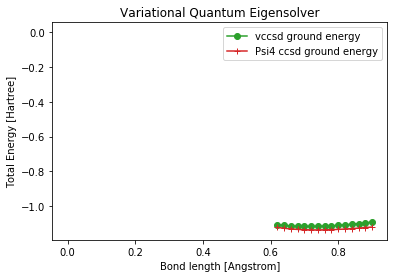

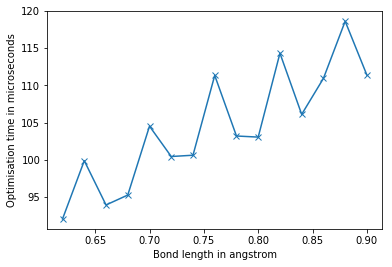

In [22]:
# %%capture printed_output
# capture output to object to display later
# so that notebook can be closed and then output seen later

from numpy import linspace
import collections
from time import time
from scipy.optimize import minimize

from _ccsd_amps import *   

def get_hamiltonian_matrix(n, ham_op):
        I = [[1,0],[0,1]]
        X = [[0,1],[1,0]]
        Y = [[0,-1j],[1j,0]]
        Z = [[1,0],[0,-1]]
        hamiltonian = np.zeros((2**n, 2**n), dtype=np.complex128)
        for term in ham_op.terms:
            string = [I, I, I, I]
            for letter in term:
                if letter[1] != I:
                    if letter[1] == 'X':
                        string[letter[0]] = X
                    if letter[1] == 'Y':
                        string[letter[0]] = Y
                    if letter[1] == 'Z':
                        string[letter[0]] = Z
            temp = string[0]
            for i in range(1, n):
                temp = np.kron(temp, string[i])
            hamiltonian += temp*ham_op.terms[term]
        return hamiltonian


def vqe_classical_processor(eng, molecular_details, r_min, r_max, n_pts):
    
    """
    Read MolecularData from HDF5 output of OpenFermion-Psi4
    Populate bond_lengths, extract hamiltonian
    """    
    vccsd_energies = []
    psi4_ccsd_energies = []
    times = []
    bond_lengths = linspace(r_min, r_max, n_pts)    
    
    folder = '/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/openfermion/data/'
    
    for i in range(n_pts):
        file_i = folder + molecular_details + str(bond_lengths[i])

        # Load data from HDF5 computed using Openfermion-Psi4
        molecule = MolecularData(filename=file_i)
        n_orbs = molecule.n_qubits
        n_elec = molecule.n_electrons
        psi4_ccsd_energies.append(molecule.ccsd_energy)
#         print('# orbitals = {} and # electrons = {}'.format(n_orbs, n_elec))

        # Extract initial guesses for CCSD single and double amplitudes
        # stored as numpy arrays
        # 1) MolecularData not storing MP2 amplitudes.. 2) faster convergence 
        ccsd_single_init = molecule.ccsd_single_amps
        ccsd_double_init = molecule.ccsd_double_amps
#         print(ccsd_single_init.shape)
#         print(ccsd_double_init.shape)
#         ccsd_single_init = np.zeros((4,4))
#         ccsd_single_init = np.random.rand(4,4)
#         ccsd_single_init = np.multiply(ccsd_single_init, 0)
#         ccsd_double_init = np.zeros((4,4,4,4))
#         ccsd_double_init[0,1,2,3] = 0.06
    
        terms = term_list(n_elec, n_orbs)
        print(terms)
        amps = populate_term_list(
            ccsd_single_init, ccsd_double_init, terms, n_elec)

        # Convert hamiltonian to QubitOperator using JW
        molecule_qubit_hamiltonian = my_jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))

        hamiltonian = get_hamiltonian_matrix(n_orbs, molecule_qubit_hamiltonian)
        energies, vecs = np.linalg.eig(hamiltonian)
        print('ground energy and state by diagonalising the hamiltonian:')
        ground = np.amin(energies)
        print(ground)
#         print(state)

        # Classical optimisation loop using scipy.optimize.minimize
        # for variational parameters theta (= CC amplitudes here)
        # Can pass different scipy optimizer options: Brent, Golden, Bounded
#         cc_quantum_coprocessor(theta_0, molecule_qubit_hamiltonian, n_orbs, n_elec)
        start = time()
        minimum = minimize(cc_quantum_coprocessor, amps,
                           args=(molecule_qubit_hamiltonian, n_orbs, n_elec, terms, eng), method='Nelder-Mead', options={'xatol':1e-5, 'fatol':1e-6, 'adaptive':True}) # 
        vccsd_energies.append(minimum.fun)
        end = time()
        duration = float(end-start)
        times.append(duration)
        
        vccsd_amps = minimum.x
        theta_0 = amps - vccsd_amps
        max_delta_amps = np.amax([abs(x) for x in theta_0])
        # save number of nonzeros for later use
        n_terms = np.count_nonzero(vccsd_amps)
#         print('after optimisation, # singles = {} and # doubles = {}'.format(len(vccsd_amps[:]), len(double_amps)))
        print('vccsd amps:')
        print(vccsd_amps)
        print('psi4 ccsd amps:')
        print(amps)
        print('max change in magnitude of any cc amplitude: {}'.format(max_delta_amps))
#         print('Optimizer success flag: {}'.format(minimum.success))
#         print('Optimizer termination status: {}'.format(minimum.status))
#         print('Optimizer message: {}'.format(minimum.message))
#         print('Optimizer output energy: {}'.format(vccsd_energies[i]))
        print('{} has vCCSD energy of {} Hartree at r={}.'.format(molecule.name, vccsd_energies[i], bond_lengths[i]))
        
    return bond_lengths, psi4_ccsd_energies, vccsd_energies, times

if __name__ == '__main__':
    molecular_details = 'H2_sto-3g_singlet_'
    r_min = 0.62
    r_max = 0.90
    n_pts = 15
    eng = MainEngine()
    bond_lengths, psi4_ccsd_energies, vccsd_energies, times = vqe_classical_processor(eng, molecular_details, 
                                                                        r_min, r_max, n_pts)
    
    # plot results of VQE calculation
    plt.figure(0)
    plt.xlabel("Bond length [Angstrom]")
    plt.ylabel("Total Energy [Hartree]")
    plt.title("Variational Quantum Eigensolver")
    plt.plot(bond_lengths, vccsd_energies, "o-",
             label="vccsd ground energy")
    plt.plot(bond_lengths, psi4_ccsd_energies, "+-",
             label="Psi4 ccsd ground energy")
    plt.legend()
    plt.axis('tight')
    plt.show()
    fname = molecular_details + '_Nelder-Mead'
    plt.savefig(fname)

    plt.figure(1)
    plt.plot(bond_lengths, times, 'x-')
    plt.ylabel('Optimisation time in seconds')
    plt.xlabel('Bond length in angstrom')
    plt.show()
    fname_t = fname + '_time'
    plt.savefig(fname_t)
    
#     ccsd_single_init = np.zeros((4,4))
#     ccsd_single_init = np.multiply(ccsd_single_init, 0.01)
#     ccsd_double_init = np.zeros((4,4,4,4))
#     ccsd_double_init[2,1] = 0.05
#     theta_0 = np.hstack([ccsd_single_init.flatten(), ccsd_double_init.flatten()])
#     cc_quantum_coprocessor(theta_0,(molecule_qubit_hamiltonian, n_orbs, n_elec, eng))


ground energy and state by diagonalising the hamiltonian:
(-1.13167634088+0j)
Measured trial energy = -1.092889363818621
Measured trial energy = -1.092889363818621
Measured trial energy = -1.092889363818621
Measured trial energy = -1.092889363818621
Measured trial energy = -1.092889363818621
Measured trial energy = -1.091595472817732
Measured trial energy = -1.0941627797168638
Measured trial energy = -1.0946663996115147
Measured trial energy = -1.093605003115942
Measured trial energy = -1.093889458581847
Measured trial energy = -1.0942859661526991
Measured trial energy = -1.0948376826148518
Measured trial energy = -1.095221525666306
Measured trial energy = -1.0957556393073322
Measured trial energy = -1.0963161251719318
Measured trial energy = -1.0961351839517683
Measured trial energy = -1.0967419776515
Measured trial energy = -1.09729947160155
Measured trial energy = -1.0975448584705576
Measured trial energy = -1.0981793516389609
Measured trial energy = -1.0985563215230874
Measured tri

/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/projectq/backends/_sim/_simulator.py:175: ComplexWarning: Casting complex values to real discards the imaginary part
  [qb.id for qb in qureg])


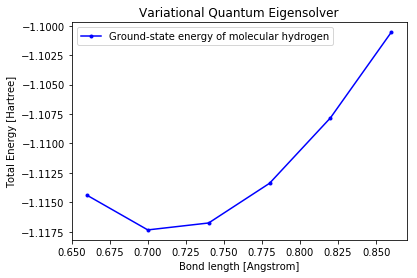

In [24]:
printed_output.show()
# H2 sto-3g Nelder-Mead


In [38]:
_oh
%%capture?
%save h2_sto3g_nelder_out.py _oh[27]
printed_output.write('H2-sto3g-Nelder.output')



'_oh[27]' was not found in history, as a file, url, nor in the user namespace.


AttributeError: 'CapturedIO' object has no attribute 'write'

In [8]:
printed_output.show()

{'0,2': 0, '0,3': 1, '1,2': 2, '1,3': 3, '0,1,2,3': 4}
ground energy and state by diagonalising the hamiltonian:
(-1.1227671716+0j)
Measured trial energy = -1.0872073723853903
Measured trial energy = -1.0872073723853903
Measured trial energy = -1.0872073723853903
Measured trial energy = -1.0872073723853903
Measured trial energy = -1.0872073723853903
Measured trial energy = -1.086019885565945
Measured trial energy = -1.0883759509021589
Measured trial energy = -1.088838077358587
Measured trial energy = -1.087864108911635
Measured trial energy = -1.088125141343478
Measured trial energy = -1.0884889896025618
Measured trial energy = -1.0889952442478237
Measured trial energy = -1.0893474458546555
Measured trial energy = -1.089837513793903
Measured trial energy = -1.0903517581100801
Measured trial energy = -1.0901857473597127
Measured trial energy = -1.0907424623436255
Measured trial energy = -1.091253924347813
Measured trial energy = -1.0914790431601435
Measured trial energy = -1.09206111094

/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/projectq/backends/_sim/_simulator.py:175: ComplexWarning: Casting complex values to real discards the imaginary part
  [qb.id for qb in qureg])
Exception ignored in: <bound method Qubit.__del__ of <projectq.types._qubit.Qubit object at 0x7f281d5b0cc0>>
Traceback (most recent call last):
  File "/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/projectq/types/_qubit.py", line 135, in __del__
    self.engine.deallocate_qubit(weak_copy)
  File "/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/projectq/cengines/_basics.py", line 153, in deallocate_qubit
    tags=[DirtyQubitTag()] if is_dirty else [])])
  File "/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/projectq/cengines/_main.py", line 288, in send
    raise compact_exception  # use verbose=True for more info
RuntimeError: Error: Qubit has not been measured / uncomputed! There is most likely a bug in your code.
 raised in:
'  File "/store/DAMTP/ss2310

In [2]:
import numpy as np
from time import time as tm
bond_lengths = np.linspace(0.62, 0.90, 15)
print(times)
print(times[0])
print(type(tm()))
# plt.subplot(121)

plt.figure(0)
plt.xlabel("Bond length [Angstrom]")
plt.ylabel("Total Energy [Hartree]")
plt.title("Variational Quantum Eigensolver")
plt.plot(bond_lengths, vccsd_energies, "o-",
         label="vccsd ground energy")
plt.plot(bond_lengths, psi4_ccsd_energies, "+-",
         label="Psi4 ccsd ground energy")
plt.legend()
plt.axis('tight')
# plt.show()
fname = molecular_details + '_Nelder-Mead'
plt.savefig(fname)

plt.figure(1)
plt.plot(bond_lengths, times, 'x-')
plt.ylabel('Optimisation time in seconds')
plt.xlabel('Bond length in angstrom')
plt.show()
fname_t = fname + '_time'
plt.savefig(fname_t)

NameError: name 'times' is not defined

In [30]:
# Set molecule parameters.
basis = '6-21g'
multiplicity = 1
bond_length = 0.5
bond_lengths += [bond_length]
geometry = [('H', (0., 0., 0.)), 
            ('H', (0., 0., bond_length)),]
molecule = MolecularData(
    geometry, basis, multiplicity,
    description=str(round(bond_length, 2)))
print(f"#qubits (spin orbitals) in {basis} basis: {molecule.n_orbitals}")

#qubits (spin orbitals) in 6-21g basis: None
